# DAT210x - Programming with Python for DS

## Module5- Lab2

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from sklearn.cluster import KMeans
# matplotlib.style.use('ggplot') # Look Pretty

In [2]:
def showandtell(title=None):
    if title != None: plt.savefig(title + ".png", bbox_inches='tight', dpi=300)
    plt.show()
    #exit()

Start by importing whatever you need to import in order to make this lab work:

### CDRs

A [call detail record](https://en.wikipedia.org/wiki/Call_detail_record) (CDR) is a data record produced by a telephone exchange or other telecommunications equipment that documents the details of a telephone call or other telecommunications transaction (e.g., text message) that passes through that facility or device.

The record contains various attributes of the call, such as time, duration, completion status, source number, and destination number. It is the automated equivalent of the paper toll tickets that were written and timed by operators for long-distance calls in a manual telephone exchange.

The dataset we've curated for you contains call records for 10 people, tracked over the course of 3 years. Your job in this assignment is to find out where each of these people likely live and where they work at!

Start by loading up the dataset and taking a peek at its head. You can convert date-strings to real date-time objects using `pd.to_datetime`, and the times using `pd.to_timedelta`:

In [3]:
df = pd.read_csv('./Datasets/CDR.csv')
print (df.head())
df.CallDate = pd.to_datetime(df.CallDate)
df.Duration = pd.to_timedelta(df.Duration)

           In         Out Direction    CallDate         CallTime  DOW  \
0  4638472273  2666307251  Incoming  2010-12-25  07:16:24.736813  Sat   
1  4638472273  1755442610  Incoming  2010-12-25  21:18:30.053710  Sat   
2  4638472273  5481755331  Incoming  2010-12-25  14:52:42.878016  Sat   
3  4638472273  1755442610  Incoming  2010-12-25  16:02:09.001913  Sat   
4  4638472273  2145623768  Incoming  2010-12-25  15:28:35.028554  Sat   

         Duration                               TowerID   TowerLat   TowerLon  
0  0:02:41.741499  0db53dd3-eb9c-4344-abc5-c2d74ebc3eec  32.731611 -96.709417  
1  0:02:47.108750  aeaf8b43-8034-44fe-833d-31854a75acbf  32.731722 -96.709500  
2  0:04:35.356341  fadaa83f-6001-45fd-aa4a-17d6c6b7ec00  32.899944 -96.910389  
3  0:02:23.498499  fadaa83f-6001-45fd-aa4a-17d6c6b7ec00  32.899944 -96.910389  
4  0:03:54.692497  95d7920d-c3cd-4d20-a568-9a55800dc807  32.899944 -96.910389  


Create a distinct list of `In` phone numbers (people) and store the values in a regular python list. Make sure the numbers appear in your list in the same order they appear in your dataframe; but only keep a single copy of each number. [This link](https://docs.scipy.org/doc/numpy/reference/generated/numpy.ndarray.tolist.html) might also be helpful.

In [4]:
in_numbers = list(df.In.unique())

Create a slice named `user1` that filters to _only_ include dataset records where the `In` feature (user's phone number) is equal to the first number on your unique list above, i.e., the very first number in the dataset:

In [5]:
user1 = df[(df.In == in_numbers[0])]

Let's go ahead and plot all the call locations:

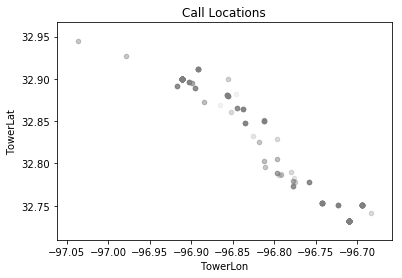

In [6]:
user1.plot.scatter(x='TowerLon', y='TowerLat', c='gray', alpha=0.1, title='Call Locations')
plt.show()

INFO: The locations map above should be too "busy" to really wrap your head around. This is where domain expertise comes into play. Your intuition can direct you by knowing people are likely to behave differently on weekends vs on weekdays:

#### On Weekends
1. People probably don't go into work
1. They probably sleep in late on Saturday
1. They probably run a bunch of random errands, since they couldn't during the week
1. They should be home, at least during the very late hours, e.g. 1-4 AM

#### On Weekdays
1. People probably are at work during normal working hours
1. They probably are at home in the early morning and during the late night
1. They probably spend time commuting between work and home everyday

Add more filters to the `user1` slice you created. Add bitwise logic so that you only examine records that _came in_ on weekends (sat/sun):

In [7]:
user1 = user1[(user1.DOW == 'Sat') | (user1.DOW == 'Sun')]

Further filter `user1` down for calls that came in either before 6AM OR after 10pm (22:00:00). Even if you didn't convert your times from string objects to timedeltas, you can still use `<` and `>` to compare the string times as long as you code them as [military time strings](https://en.wikipedia.org/wiki/24-hour_clock), eg: "06:00:00", "22:00:00": 

You may also want to review the Data Manipulation section for this. Once you have your filtered slice, print out its length:

In [8]:
user1 = user1[(user1.CallTime < "06:00:00") | (user1.CallTime > "22:00:00")]
print(len(user1))

28


Visualize the dataframe with a scatter plot as a sanity check. Since you're [familiar with maps](https://en.wikipedia.org/wiki/Geographic_coordinate_system#Geographic_latitude_and_longitude), you know well that your X-Coordinate should be Longitude, and your Y coordinate should be the tower Latitude. Check the dataset headers for proper column feature names.
 
At this point, you don't yet know exactly where the user is located just based off the cell phone tower position data; but considering the below are for Calls that arrived in the twilight hours of weekends, it's likely that wherever they are bunched up is probably near where the caller's residence:

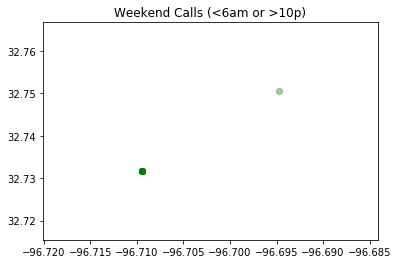

In [16]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(user1.TowerLon,user1.TowerLat, c='g', marker='o', alpha=0.2)
ax.set_title('Weekend Calls (<6am or >10p)')
plt.show()

Run K-Means with a `K=1`. There really should only be a single area of concentration. If you notice multiple areas that are "hot" (multiple areas the user spends a lot of time at that are FAR apart from one another), then increase `K=2`, with the goal being that one of the centroids will sweep up the annoying outliers; and the other will zero in on the user's approximate home location. Or rather the location of the cell tower closest to their home.....

Be sure to only feed in Lat and Lon coordinates to the KMeans algorithm, since none of the other data is suitable for your purposes. Since both Lat and Lon are (approximately) on the same scale, no feature scaling is required. Print out the centroid locations and add them onto your scatter plot. Use a distinguishable marker and color.

Hint: Make sure you graph the CORRECT coordinates. This is part of your domain expertise.

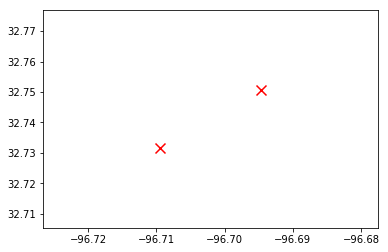

In [31]:
kmeans = KMeans(n_clusters = 2)
user1 = pd.concat([user1.TowerLon, user1.TowerLat], axis = 1)
labels = kmeans.fit_predict(user1)

centroids = kmeans.cluster_centers_
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(centroids[:, 0], centroids[:, 1], c = 'r', marker = 'x', s = 100)
showandtell()

Now that you have a system in place, repeat the above steps for all 10 individuals in the dataset, being sure to record their approximate home locations. You might want to use a for-loop, unless you enjoy copying and pasting:

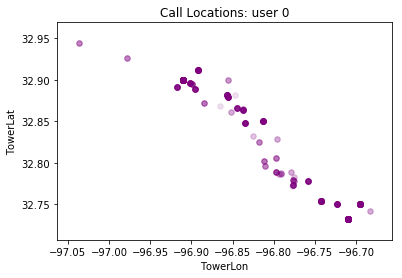

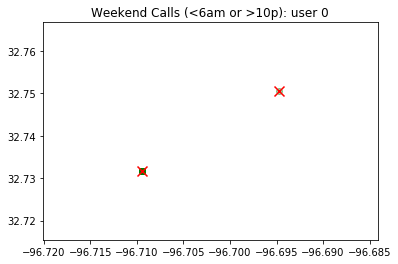

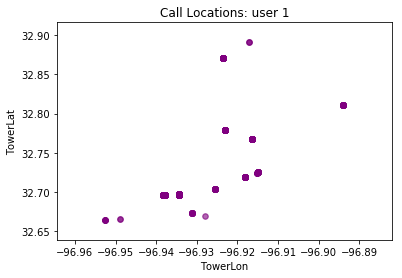

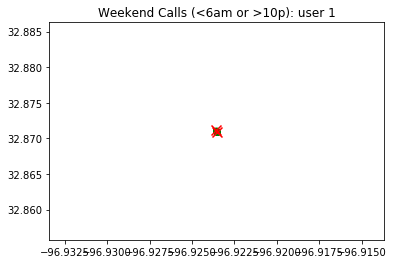

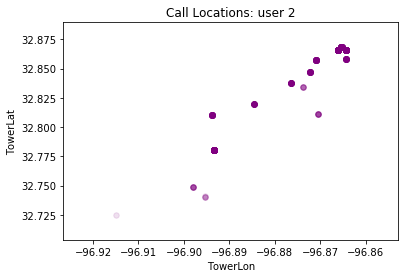

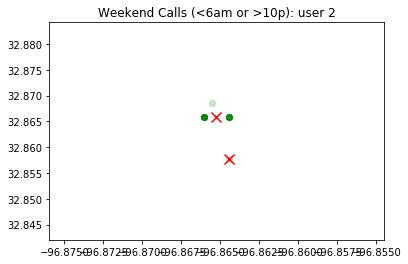

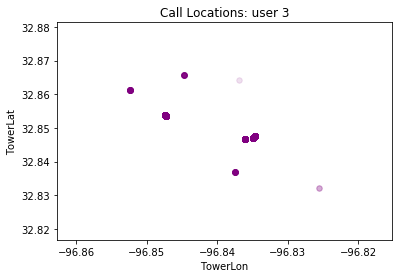

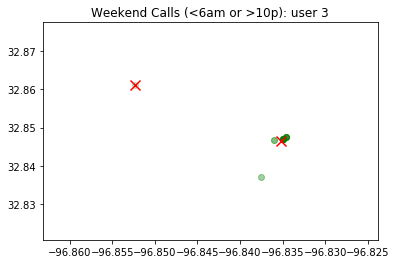

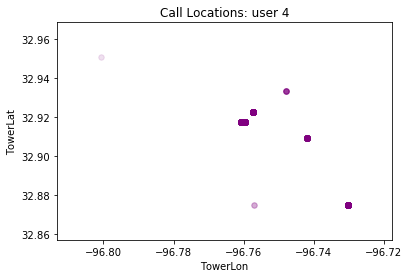

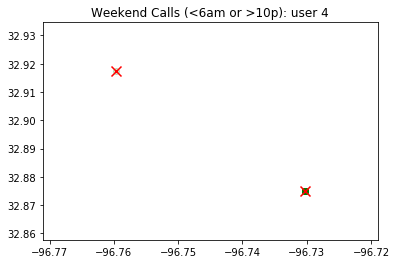

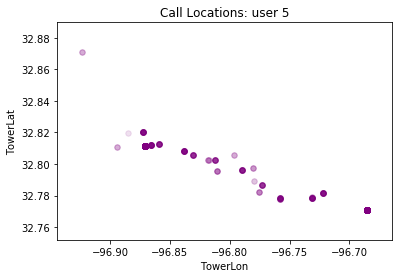

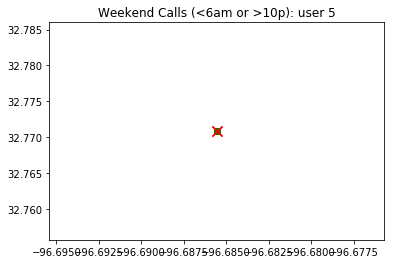

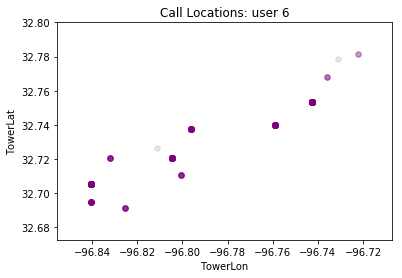

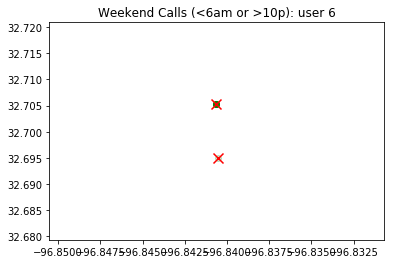

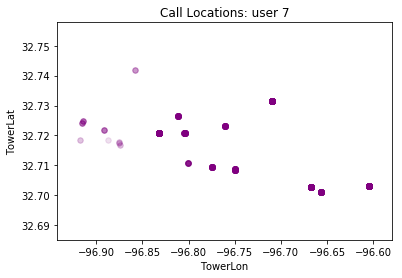

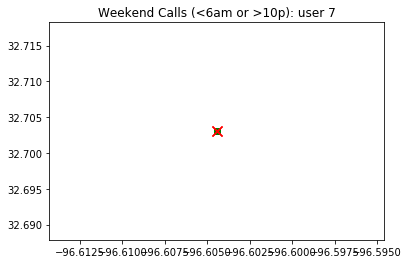

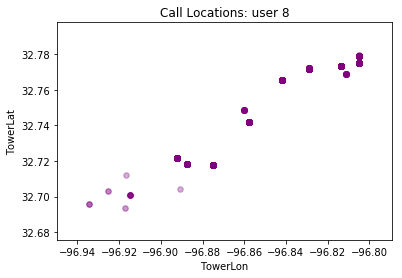

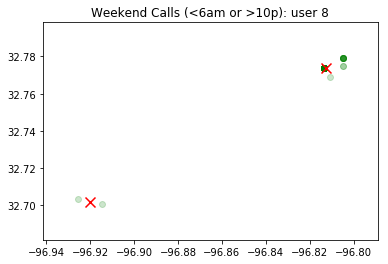

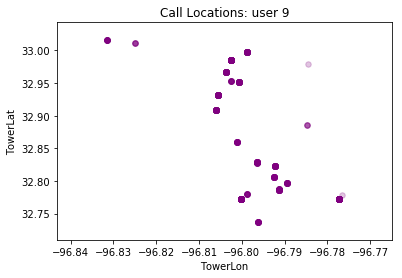

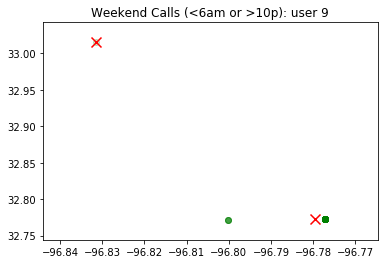

In [34]:
locations = []

for i in range(10):

    user = df[(df.In == in_numbers[i])]
    user.plot.scatter(x='TowerLon', y='TowerLat', c='purple', alpha=0.12, title='Call Locations: user ' + str(i), s = 30)
    user = user[(user.DOW == 'Sat') | (user.DOW == 'Sun')]
    user = user[(user.CallTime < "06:00:00") | (user.CallTime > "22:00:00")]
    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.scatter(user.TowerLon, user.TowerLat, c='g', marker='o', alpha=0.2)
    ax.set_title('Weekend Calls (<6am or >10p): user ' + str(i))
    
    kmeans = KMeans(n_clusters = 2)
    user = pd.concat([user.TowerLon, user.TowerLat], axis = 1)
    labels = kmeans.fit_predict(user)

    centroids = kmeans.cluster_centers_
    ax.scatter(x = centroids[:, 0], y = centroids[:, 1], c = 'r', marker = 'x', s = 100)
    locations.append(centroids)

showandtell()